In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier


In [5]:
dataset = load_dataset("lex_glue",'ecthr_a')

Reusing dataset lex_glue (/Users/ytkd/.cache/huggingface/datasets/lex_glue/ecthr_a/1.0.0/c3c0bd7433b636dc39ae49a84dc401190c73156617efc415b04e9835a93a7043)
100%|██████████| 3/3 [00:00<00:00, 227.87it/s]


In [6]:
train = dataset['train']
test = dataset['test']


--> pre_process: creating a pre-process funciton which will take the data, perform the following operations and return features and labels
separately: 

1) Convert everything to lower case
2) Remove Stopwords
3) Tokenize the sentences (Also Removing punctuatios and non alpha numeric characters)
4) Lemmatize the words
5) Stemming the words

All these operations are performed using the NLTK package in python.

--> create_corpus : This function is used to convert our entire training data (after the pre-processing) into a corpus of words

--> convert_2d: This funciton is written to covert the 3-dimensional data into 2 dimensional.
After pre-processing we have a list of lists of lists. But labels we have are the violation of articles and are present for
every document and not every sentence. Hence the desired format we need to train the model is a list of lists. Where one
list is the entrie training data of size 9000 and the second list (list of list) is the documents inside the main list of 9000.

In [111]:
def pre_process(data):
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    new_data = []
    new_labels = []
    for i in range(len(data)):
        tokenized = [tokenizer.tokenize(entry.lower()) for entry in data[i]['text'] if entry not in stopwords.words('english') and len(entry)>1]
        lemmatized = [[lemmatizer.lemmatize(token) for token in sent] for sent in tokenized]
        stemming = [[stemmer.stem(token) for token in sent] for sent in lemmatized]
        new_data.append(stemming)
        new_labels.append(data[i]['labels'])
    print('Lower Case + Tokenization + Stop Words Remowal + Only Alphanumeric (Removing Punctuation) + Lemmatization + Stemming',stemming[0])
    return new_data, new_labels

def create_corpus(data):
    corpus = []
    for doc in data:
        for sen in doc:
            for word in sen:
                corpus.append(word)
    return corpus   

def convert_2d(data):
    lst2 = []
    for i in data:
        lst1 = []
        for j in i:
            for k in j:
                lst1.append(k)
        lst2.append(lst1)
    return lst2

def identity_tokenizer(text):
    return text



In [112]:
train_X, train_y  = pre_process(train) 
test_X, test_y = pre_process(test)

In [106]:
corpus_train  = create_corpus(train_X)
corpus_test = create_corpus(test_X)
 = corpus_train+corpus_test

In [107]:
train_X_2d = convert_2d(train_X)
test_X_2d = convert_2d(test_X)

In [27]:
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)
tfidf.fit(total_corpus)
vectors_train = tfidf.fit_transform(train_X_2d)
vectors_test = tfidf.transform(test_X_2d)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


In [29]:
binarizer = MultiLabelBinarizer()
train_y_enc = binarizer.fit_transform(train_y)
test_y_enc = binarizer.transform(test_y)

Below is an example of how a Multilabel binarizer works. For the 9th document in the test dataset articles 3 and 4 were violated. The label binarizer will create a binary representation with the size equal to the total number of unique labels which is 10 in our case. This is done in order for the classifers to interpret the multiple labels in a single instance.

In [30]:
print('Articles violated in the 9th document of the test dataset are ',test_y[8])
print('After applying Multi Label Binarizer',list(test_y_enc[8]))

Articles violated in the 9th document of the test dataset are  [3, 4]
After applying Multi Label Binarizer [0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


In [55]:
classification_models = [
                         OneVsRestClassifier(LinearSVC(), n_jobs=-1),
                         RandomForestClassifier(n_jobs=-1),
                         OneVsRestClassifier(naive_bayes.MultinomialNB()),
                         OneVsRestClassifier(DecisionTreeClassifier()),
                         LabelPowerset(LinearSVC())
                         ]

model_scores = []
for model in classification_models:
  # Pipeline object is created to perform model training and evaluate the performance of each model.
  model_pipeline = Pipeline([('model_training', model)])
  model_pipeline.fit(vectors_train, train_y_enc)

  model_name = model
  if model_name=='SVC' and model.kernel=='rbf': 
    model_name+='RBF kernel'
  
  model_scores.append((model_name,(f'{100*model_pipeline.score(vectors_test, test_y_enc):.2f}%')))

# Create the dataframe for score of each model
df_model_scores = pd.DataFrame(model_scores,columns=['Classification Model','Accuracy Score'])
df_model_scores.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classification Model,Accuracy Score
4,"LabelPowerset(classifier=LinearSVC(), require_...",57.40%
0,"OneVsRestClassifier(estimator=LinearSVC(), n_j...",50.00%
3,OneVsRestClassifier(estimator=DecisionTreeClas...,34.70%
1,"(DecisionTreeClassifier(max_features='sqrt', r...",32.10%
2,OneVsRestClassifier(estimator=MultinomialNB()),25.20%


In [101]:
classifier = LabelPowerset(LinearSVC())
from sklearn.metrics import accuracy_score
classifier.fit(vectors_train,train_y_enc)
predictions = classifier.predict(vectors_test)
print('Accuracy of the Label Powerset model with Linear SVC is',accuracy_score(predictions, test_y_enc)*100,'%')
class_report = classification_report(test_y_enc, predictions)
print(class_report)

Accuracy of the Label Powerset model with Linear SVC is 57.4 %
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        56
           1       0.83      0.78      0.80       189
           2       0.81      0.66      0.73       166
           3       0.65      0.82      0.72       299
           4       0.72      0.43      0.54       123
           5       0.67      0.40      0.50         5
           6       0.72      0.43      0.54        77
           7       0.81      0.57      0.67        37
           8       0.00      0.00      0.00        16
           9       0.76      0.70      0.73       122

   micro avg       0.73      0.68      0.71      1090
   macro avg       0.67      0.56      0.60      1090
weighted avg       0.73      0.68      0.70      1090
 samples avg       0.65      0.61      0.61      1090



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
classification_matrix = multilabel_confusion_matrix(test_y_enc, predictions)

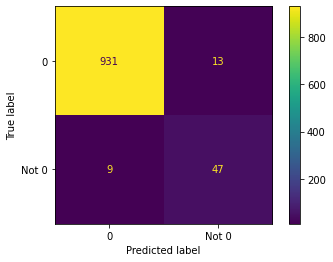

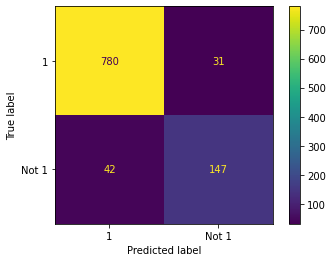

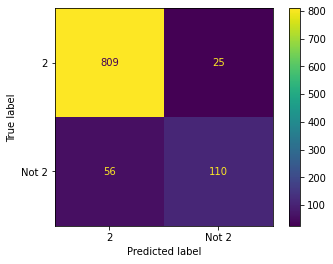

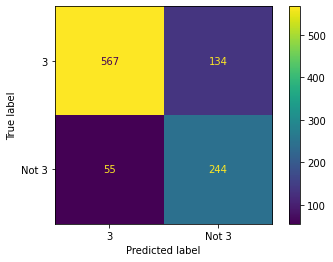

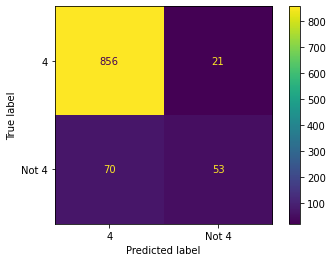

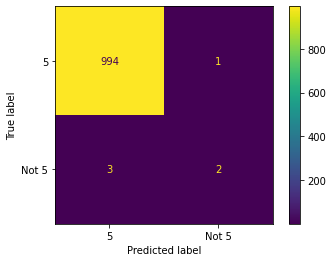

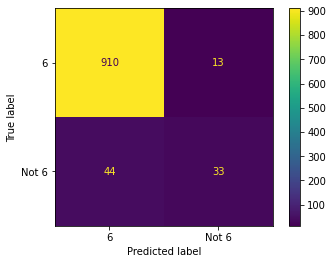

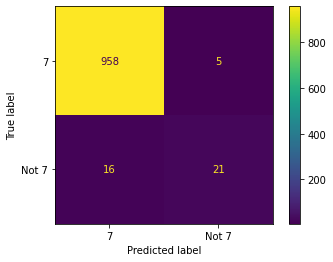

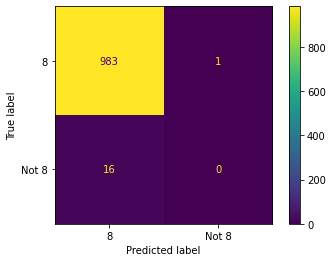

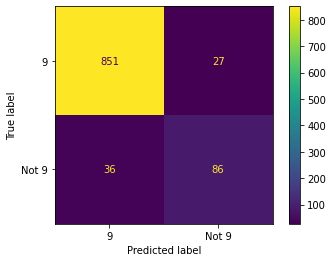

In [95]:
for i in range(len(classification_matrix)):
    disp = ConfusionMatrixDisplay(confusion_matrix=classification_matrix[i],display_labels=[i,f'Not {i}'])
    disp.plot()


5